## Train/Test Split Stratified on Primary Site

In [2]:
import pandas as pd

In [ ]:
X = pd.read_hdf("/scratch/rcurrie/tumornormal/tcga_target_gtex.h5", "expression")
Y = pd.read_hdf("/scratch/rcurrie/tumornormal/tcga_target_gtex.h5", "labels")

In [40]:
# Convert tumor_normal and primary_site into numerical values for stratification and one hot encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)

In [43]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X.values, Y["primary_site"]):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    primary_site_train, primary_site_test = \
        Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

In [ ]:
# Lets see how big each class is based on primary site
import matplotlib.pyplot as plt
plt.hist(Y_train.primary_site_value, alpha=0.5, label='Train')
plt.hist(Y_test.primary_site_value, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

In [ ]:
# Export h5 format files
with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_target_gtex.h5", "w") as store:
    store["expression"] = X
    store["labels"] = Y

with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_target_gtex_train.h5", "w") as store:
    store["expression"] = X_train
    store["labels"] = Y_train

with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_target_gtex_test.h5", "w") as store:
    store["expression"] = X_test
    store["labels"] = Y_test

## Train/Test Split Expression by Mutation

In [50]:
print(X.shape, Y.shape)
assert X.index.equals(Y.index)

(19126, 58581) (19126, 9)


In [61]:
Y_mutation = pd.read_csv("/scratch/rcurrie/bme230b/TCGA_phenotype_mutation_data.tsv", sep="\t")
Y_mutation.rename(columns = {'sample':'id'}, inplace=True)
Y_mutation.set_index("id", inplace=True)
print("Rows missing in original dataset:", Y_mutation.index.difference(Y.index))
Y_mutation.drop(Y_mutation.index.difference(Y.index), inplace=True)
Y_mutation.sort_index(inplace=True)
print(Y_mutation.shape)
Y_mutation.head()

Rows missing in original dataset: Index(['TCGA-07-0249-20'], dtype='object', name='id')
(10534, 10)


,detailed_category,primary.disease.or.tissue,X_primary_site,X_sample_type,X_gender,X_study,TP53_mutant,KRAS_mutant,BRAF_mutant,dataset
id,,,,,,,,,,
TCGA-02-0047-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA,0,0,0,training
TCGA-02-0055-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Female,TCGA,1,0,0,training
TCGA-02-2483-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA,1,0,0,training
TCGA-02-2485-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA,1,0,0,training
TCGA-04-1331-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,1,0,0,training


In [62]:
X_mutation = X[X.index.isin(Y_mutation.index)]
X_mutation.sort_index(inplace=True)
print(X_mutation.shape)
X_mutation.head()

(10534, 58581)


,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
TCGA-02-0047-01,-9.966042,-9.965816,-1.639388,4.7872,2.3337,-9.9658,9.0886,1.9822,0.1257,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.706089,-2.3147
TCGA-02-0055-01,-9.966042,-9.965816,-9.965880,6.0646,2.4144,-9.9658,8.9694,0.7493,-4.0350,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,0.576300,-9.9658
TCGA-02-2483-01,-9.966042,-9.965816,-9.965880,5.5910,2.0569,-9.9658,8.1125,-0.3940,-3.6259,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,1.761701,-9.9658
TCGA-02-2485-01,-9.966042,-9.965816,-9.965880,3.4997,0.9789,-9.9658,6.9560,-1.2142,2.0500,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,2.543747,-9.9658
TCGA-04-1331-01,-9.966042,-9.965816,-3.046901,5.0273,2.6371,-9.9658,6.2599,0.3115,1.7141,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,2.257319,-2.5479


In [63]:
Y_mutation_train = Y_mutation[Y_mutation.dataset == "training"]
X_mutation_train = X_mutation[X_mutation.index.isin(Y_mutation_train.index)]

Y_mutation_test = Y_mutation[Y_mutation.dataset == "test"]
X_mutation_test = X_mutation[X_mutation.index.isin(Y_mutation_test.index)]

In [64]:
print("All:", Y_mutation.shape, X_mutation.shape)
print("Train:", Y_mutation_train.shape, X_mutation_train.shape)
print("Test:", Y_mutation_test.shape, X_mutation_test.shape)

All: (10534, 10) (10534, 58581)
Train: (8520, 10) (8520, 58581)
Test: (2014, 10) (2014, 58581)


In [67]:
assert set(Y_mutation_test.dataset.values) == {'test'}
assert set(Y_mutation_train.dataset.values) == {'training'}
assert X_mutation_test.index.equals(Y_mutation_test.index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8a481e6a0>,
      dtype=object)

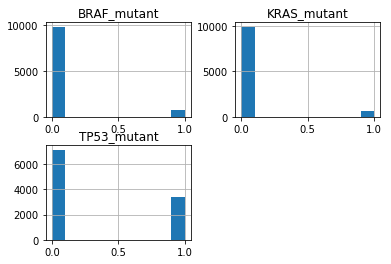

In [79]:
Y_mutation.hist()

In [68]:
# Export h5 format files
with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_mutation.h5", "w") as store:
    store["expression"] = X_mutation
    store["labels"] = Y_mutation

with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_mutation_train.h5", "w") as store:
    store["expression"] = X_mutation_train
    store["labels"] = Y_mutation_train

with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_mutation_test.h5", "w") as store:
    store["expression"] = X_mutation_test
    store["labels"] = Y_mutation_test

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['detailed_category', 'primary.disease.or.tissue', 'X_primary_site', 'X_sample_type', 'X_gender', 'X_study', 'dataset']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# Export TSV for the R folks
X_mutation_train = pd.read_hdf("/scratch/rcurrie/bme230b/tcga_mutation_train.h5", "expression")
X_mutation.to_csv("/scratch/rcurrie/bme230b/tcga_mutation_train_expression.tsv", sep='\t')
Y_mutation_train = pd.read_hdf("/scratch/rcurrie/bme230b/tcga_mutation_train.h5", "labels")
Y_mutation.to_csv("/scratch/rcurrie/bme230b/tcga_mutation_train_labels.tsv", sep='\t')

In [9]:
# Export TSV for the R folks
X_mutation_test = pd.read_hdf("/scratch/rcurrie/bme230b/tcga_mutation_test.h5", "expression")
X_mutation_test.to_csv("/scratch/rcurrie/bme230b/tcga_mutation_test_expression.tsv", sep='\t')
Y_mutation_test = pd.read_hdf("/scratch/rcurrie/bme230b/tcga_mutation_test.h5", "labels")
Y_mutation_test.to_csv("/scratch/rcurrie/bme230b/tcga_mutation_test_labels.tsv", sep='\t')

In [17]:
# Generate un-labeled test set and strip the sample id's for competition
X_mutation_test = pd.read_hdf("/scratch/rcurrie/bme230b/tcga_mutation_test.h5", "expression")
X_mutation_test.set_index(pd.Series(range(X_mutation_test.shape[0])), inplace=True)
with pd.HDFStore("/scratch/rcurrie/bme230b/tcga_mutation_test_unlabeled.h5", "w") as store:
    store["expression"] = X_mutation_test